### Behavior Cloning

#### Load Data

In [1]:
# LOAD DATA
# Import Modules
import argparse
import cv2
import os
import csv
import base64
import numpy as np
import tensorflow as tf
import pickle
import pandas as pd
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
import random
from sklearn.utils import shuffle
from collections import deque
from scipy.stats import norm
from tqdm import tqdm
%matplotlib inline
import json
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import backend as K
import h5py

print('Import Modules')

Using TensorFlow backend.


Import Modules


In [2]:
# LOAD DATA
# Load Data Directory
os.chdir('..')
OS=os.getcwd()
os.chdir(OS+'/Training-Data')
OS=os.getcwd()

# Load Image Names, Steering Angle & Speed from CSV File
Data=[]
with open('DrivingLog.csv') as File:
    Reader=csv.reader(File)
    for i in Reader:
        Data.append(i)
with open('DrivingLog2.csv') as File:
    Reader=csv.reader(File)
    for i in Reader:
        Data.append(i)
print("CSV Data Imported")
DataLog=pd.read_csv('DrivingLog.csv',names=['Center','Left','Right','Steering','Throttle','Brake','Speed'])
SteeringField=['steering']
Steering01=pd.read_csv('DrivingLog.csv',skipinitialspace=True,usecols=SteeringField)
Steering02=pd.read_csv('DrivingLog2.csv')

# Change Directory
os.chdir('..')

CSV Data Imported


#### Analyze Data

In [3]:
# ANALYZE DATA
# Check Data Characteristics
DataSize=len(Data)
print('Size of Data:',DataSize)

Size of Data: 7258


In [4]:
# LOAD DATA
# Check Data Characteristics
DataLog.iloc[1005:1020]

,Center,Left,Right,Steering,Throttle,Brake,Speed
1005,/home/umer/Documents/Udacity-Self-Driving-Car/...,/home/umer/Documents/Udacity-Self-Driving-Car...,/home/umer/Documents/Udacity-Self-Driving-Car...,0,0.7516615,0,13.68903
1006,/home/umer/Documents/Udacity-Self-Driving-Car/...,/home/umer/Documents/Udacity-Self-Driving-Car...,/home/umer/Documents/Udacity-Self-Driving-Car...,0,1,0,14.80792
1007,/home/umer/Documents/Udacity-Self-Driving-Car/...,/home/umer/Documents/Udacity-Self-Driving-Car...,/home/umer/Documents/Udacity-Self-Driving-Car...,0,0.9260018,0,16.01524
1008,/home/umer/Documents/Udacity-Self-Driving-Car/...,/home/umer/Documents/Udacity-Self-Driving-Car...,/home/umer/Documents/Udacity-Self-Driving-Car...,-0.1489077,0.5923572,0,16.95836
1009,/home/umer/Documents/Udacity-Self-Driving-Car/...,/home/umer/Documents/Udacity-Self-Driving-Car...,/home/umer/Documents/Udacity-Self-Driving-Car...,-0.05315924,0.2504106,0,17.30095
1010,/home/umer/Documents/Udacity-Self-Driving-Car/...,/home/umer/Documents/Udacity-Self-Driving-Car...,/home/umer/Documents/Udacity-Self-Driving-Car...,0,0,0,16.77734
1011,/home/umer/Documents/Udacity-Self-Driving-Car/...,/home/umer/Documents/Udacity-Self-Driving-Car...,/home/umer/Documents/Udacity-Self-Driving-Car...,0,0,0,16.56079
1012,/home/umer/Documents/Udacity-Self-Driving-Car/...,/home/umer/Documents/Udacity-Self-Driving-Car...,/home/umer/Documents/Udacity-Self-Driving-Car...,0,0,0,16.93422
1013,/home/umer/Documents/Udacity-Self-Driving-Car/...,/home/umer/Documents/Udacity-Self-Driving-Car...,/home/umer/Documents/Udacity-Self-Driving-Car...,-0.1730332,0,0,16.19351
1014,/home/umer/Documents/Udacity-Self-Driving-Car/...,/home/umer/Documents/Udacity-Self-Driving-Car...,/home/umer/Documents/Udacity-Self-Driving-Car...,0,0,0,15.99459


Observation: Data suggests most of the steering angles are 0. Also, the data is unsymmetrical
It would be better if existing data could be augmented by adding flipped data


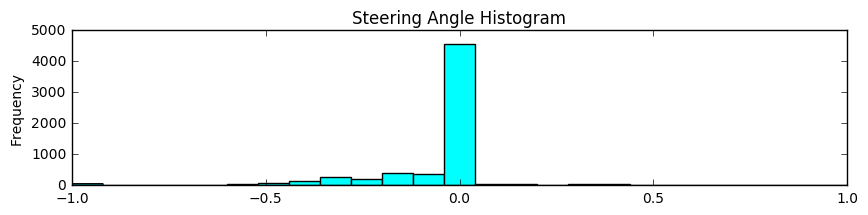

In [5]:
# ANALYZE DATA
# Check Steering Data
Steering01['steering'].plot.hist(bins=25,color='cyan',figsize=(10,2),title='Steering Angle Histogram',
                                fontsize=10)

print('Observation: Data suggests most of the steering angles are 0. Also, the data is unsymmetrical')
print('It would be better if existing data could be augmented by adding flipped data')

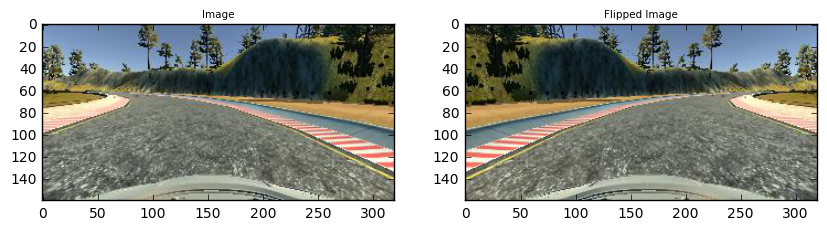

In [6]:
# ANALYZE DATA
# Read Any Center Image Name from CSV & Plot
Img=Img=plt.imread(Data[1][0].lstrip(' '))
ImgFlip=cv2.flip(Img,1)
Fig,(Axis1,Axis2)=plt.subplots(1,2,figsize=(10,10))
Axis1.imshow(Img)
Axis1.set_title('Image',fontsize=7.5)
Axis2.imshow(ImgFlip)
Axis2.set_title('Flipped Image',fontsize=7.5)

In [7]:
# ANALYZE DATA
# Read Any Center Image Name from CSV & Plot
Img=Img=plt.imread(Data[1][0].lstrip(' '))
print('Image Size:',Img.shape)

Image Size: (160, 320, 3)


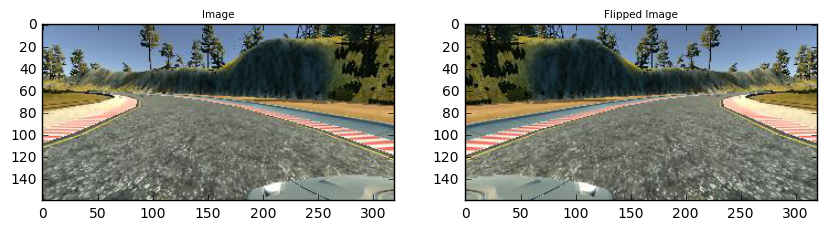

In [8]:
# ANALYZE DATA
# Read Any Left Image Name from CSV & Plot
Img=Img=plt.imread(Data[1][1].lstrip(' '))
ImgFlip=cv2.flip(Img,1)
Fig,(Axis1,Axis2)=plt.subplots(1,2,figsize=(10,10))
Axis1.imshow(Img)
Axis1.set_title('Image',fontsize=7.5)
Axis2.imshow(ImgFlip)
Axis2.set_title('Flipped Image',fontsize=7.5)

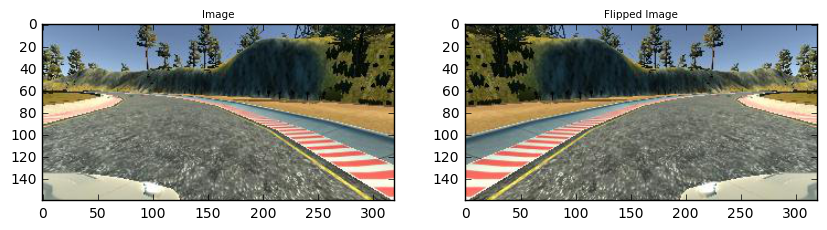

In [9]:
# ANALYZE DATA
# Read Any Right Image Name from CSV & Plot
Img=Img=plt.imread(Data[1][2].lstrip(' '))
ImgFlip=cv2.flip(Img,1)
Fig,(Axis1,Axis2)=plt.subplots(1,2,figsize=(10,10))
Axis1.imshow(Img)
Axis1.set_title('Image',fontsize=7.5)
Axis2.imshow(ImgFlip)
Axis2.set_title('Flipped Image',fontsize=7.5)

In [10]:
# ANALYZE DATA
# Set Y Limits for Filtering
YLow=65
YHigh=135
DownsampleFactor=4

# Crop the Image & Plot
CropImg=plt.imread(Data[1][0].lstrip(' '))[YLow:YHigh:DownsampleFactor,0:-1:DownsampleFactor,:]
print('Cropped Image Size:',CropImg.shape)

Cropped Image Size: (18, 80, 3)


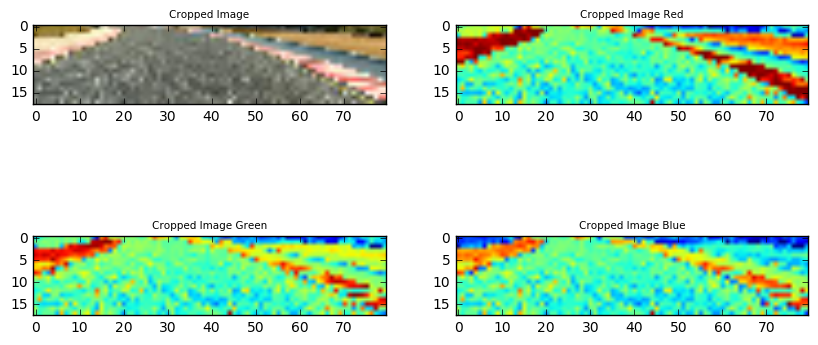

In [11]:
# ANALYZE DATA
# Plot Cropped Image
Fig,((Axis1,Axis2),(Axis3,Axis4))=plt.subplots(2,2,figsize=(10,5))
Axis1.imshow(CropImg)
Axis1.set_title('Cropped Image',fontsize=7.5)
Axis2.imshow(CropImg[:,:,0])
Axis2.set_title('Cropped Image Red',fontsize=7.5)
Axis3.imshow(CropImg[:,:,1])
Axis3.set_title('Cropped Image Green',fontsize=7.5)
Axis4.imshow(CropImg[:,:,2])
Axis4.set_title('Cropped Image Blue',fontsize=7.5)

In [13]:
# LOAD DATA
# Initialize Emtpy Generators for Feature and Labels
Features=()
Labels=()

# Define a Function to Load Image
def LoadImage(DataLine,J,YLow,YHigh,DownsampleFactor):
    Img=plt.imread(DataLine[J].lstrip(' '))[YLow:YHigh:DownsampleFactor,0:-1:DownsampleFactor,:]
    Lis=Img.flatten().tolist()
    return Lis

def LoadFlippedImage(DataLine,J,YLow,YHigh,DownsampleFactor):
    Img=plt.imread(DataLine[J].lstrip(' '))[YLow:YHigh:DownsampleFactor,0:-1:DownsampleFactor,:]
    Img=cv2.flip(Img,1)
    Lis=Img.flatten().tolist()
    return Lis

In [14]:
# LOAD DATA
# Convert Camera Images to Single List
for i in range(1,(int(len(Data)))):
    for j in range(0,1):
        if len(Features)==0:
            Features=(LoadImage(Data[i],j,YLow,YHigh,DownsampleFactor))
        else:
            Features+=(LoadImage(Data[i],j,YLow,YHigh,DownsampleFactor))
            
# Print Feature Size            
FeatureSize=int(len(Features))
print("Feature Size",FeatureSize)

Feature Size 31350240


In [15]:
# LOAD FLIPPED DATA
# Convert Camera Images to Single List
for i in range(1,(int(len(Data)))):
    for j in range(0,1):
        if len(Features)==0:
            Features=(LoadFlippedImage(Data[i],j,YLow,YHigh,DownsampleFactor))
        else:
            Features+=(LoadFlippedImage(Data[i],j,YLow,YHigh,DownsampleFactor))
            
# Print Feature Size            
FeatureSize=int(len(Features))
print("Feature Size",FeatureSize)

Feature Size 62700480


In [16]:
# LOAD DATA
# Convert back to the original image shapes
FeaturesNew=np.array(Features).reshape(2*(len(Data)-1),18,80,3)
print("Features Shape",FeaturesNew.shape)

Features Shape (14514, 18, 80, 3)


In [17]:
# LOAD DATA
# Save Labels  
# Initialize Emtpy Generators for Feature and Labels
Labels=()

for i in range(1,(int(len(Data)))):
    Labels+=(float(Data[i][3]),)

# Augment Labels for Flipped Images
for i in range(1,(int(len(Data)))):
    Labels+=(-float(Data[i][3]),)

# Save as Array
Labels=np.array(Labels)

print("Labels:",Labels.shape)

Labels: (14514,)


#### Load Training & Test Data

In [18]:
# LOAD TRAINING & TEST DATA
# Load Randomized Training & Test Data 
XTrain,XTest,YTrain,YTest=train_test_split(
    FeaturesNew,
    Labels,
    test_size=0.10,
    random_state=832289)

# Load Randomized Training & Validation Data 
XTrain, XValid,YTrain,YValid =train_test_split(
    XTrain,
    YTrain,
    test_size=0.25,
    random_state=832289)

#### Analyze Training, Test & Validation Data

In [19]:
# ANALYZE TRAINING, TEST & VALIDATION DATA
# Compute Data Shapes
TrainSize=XTrain.shape[0]
TestSize=XTest.shape[0]
ValidSize=XValid.shape[0]
InputShape=XTrain.shape[1:]
FeatureNum=XTrain.shape[1]*XTrain.shape[2]*XTrain.shape[3]

# Print
print("Training Data Size:",TrainSize)
print("Test Data Size:",TestSize)
print("Validation Data Size:",ValidSize)
print("Input Shape:",InputShape)
print("Number of Features:",FeatureNum)

Training Data Size: 9796
Test Data Size: 1452
Validation Data Size: 3266
Input Shape: (18, 80, 3)
Number of Features: 4320


#### Save Data

In [20]:
# SAVE DATA
# Set Filename
PickleFilename='Training-Data/Drive.pickle'

# Save Pickle File
with open(PickleFilename,'wb') as PickleFile:
                pickle.dump(
                    {
                        'TrainDataset':XTrain,
                        'TrainLabels':YTrain,
                        'ValidDataset':XValid,
                        'ValidLabels':YValid,
                        'TestDataset':XTest,
                        'TestLabels':YTest,
                    },
                    PickleFile,pickle.HIGHEST_PROTOCOL)

print('Training, Test & Validation Data Saved!')

Training, Test & Validation Data Saved!


#### Load Data

In [21]:
# LOAD DATA
# Load Training, Test & Validation Data from Pickle File
PickleFilename='Training-Data/Drive.pickle'
with open(PickleFilename,'rb') as PickleFile:
    # Load Data from File
    PickleData=pickle.load(PickleFile)

    # Load Training, Test & Validation Data
    XTrain=PickleData['TrainDataset']
    YTrain=PickleData['TrainLabels']
    XValid=PickleData['ValidDataset']
    YValid=PickleData['ValidLabels']
    XTest=PickleData['TestDataset']
    YTest=PickleData['TestLabels']

    # Delete Pickle Data to Free the Memory
    del PickleData  

print('Training, Test & Validation Data Imported from Pickle File')

Training, Test & Validation Data Imported from Pickle File


In [22]:
# LOAD DATA
# Read Data Characteristics
print("Training Data Feature Size:",XTrain.shape)
print("Train Labels Size:",YTrain.shape)
print("Test Features Size:",XTest.shape)
print("Test Labels Size:",YTest.shape)
print("Valid Features Size:",XValid.shape)
print("Valid Labels Size:",YValid.shape)
InputShape=XTrain.shape[1:]
print("Input Shape:",InputShape)

Training Data Feature Size: (9796, 18, 80, 3)
Train Labels Size: (9796,)
Test Features Size: (1452, 18, 80, 3)
Test Labels Size: (1452,)
Valid Features Size: (3266, 18, 80, 3)
Valid Labels Size: (3266,)
Input Shape: (18, 80, 3)


#### Preprocess Data

In [23]:
# PREPROCESS DATA
# Divide the Data by 255 & Subtract -0.5 from it
XTrain=XTrain.astype('float32')
XValid=XValid.astype('float32')
XTest=XTest.astype('float32')
XTrain/=255
XValid/=255
XTest/=255
XTrain-=0.5
XValid-=0.5
XTest-=0.5

#### Training Model

In [24]:
# TRAINING MODEL
# Set the Parameters and print out the summary of the model
np.random.seed(1337)  
BatchSize=64
Classes=1 
Epoch=15 

In [25]:
# TRAINING MODEL
# Design the Model
print('Model Design!')

# Set Number of Convolutional Filters
Filter01=16
Filter02=8
Filter03=4
Filter04=2

# Set the Size of Pooling Area for Max Pooling
PoolSize=(2,2)

# Set the Kernel Size
KernelSize=(3,3)

# Initiating the Model
Model=Sequential()

# The First Convolutional Layer Converts 3 Channels into 16 Channels
Model.add(Convolution2D(Filter01,KernelSize[0],KernelSize[1],
						border_mode='valid',
						input_shape=InputShape))
						
# Activation via ELU
Model.add(Activation('elu'))

# The Second Convolutional Layer Converts 16 Channels into 8 Channels
Model.add(Convolution2D(Filter02,KernelSize[0],KernelSize[1]))

# Activation via ELU
Model.add(Activation('elu'))

# The Third Convolutional Layer Converts 8 Channels into 4 Channels
Model.add(Convolution2D(Filter03,KernelSize[0],KernelSize[1]))

# Activatoin via ELU
Model.add(Activation('elu'))

# The Fourth Convolutional Layer Converts 4 Channels into 2 Channels
Model.add(Convolution2D(Filter04,KernelSize[0],KernelSize[1]))

# Activatoin via ELU
Model.add(Activation('elu'))

# Apply Max Pooling for each 2x2 Pixels
Model.add(MaxPooling2D(pool_size=PoolSize))

# Apply Dropout of 25%
Model.add(Dropout(0.25))

# Apply Flattening
Model.add(Flatten())

# Add Dense
Model.add(Dense(16))

# Activatoin via ELU
Model.add(Activation('elu'))

# Add Dense
Model.add(Dense(16))

# Activatoin via ELU
Model.add(Activation('elu'))

# Add Dense
Model.add(Dense(16))

# Activatoin via ELU
Model.add(Activation('elu'))

# Apply Dropout of 50%
Model.add(Dropout(0.5))

# Add Dense
Model.add(Dense(Classes))

# Print Model Summary
Model.summary()

Model Design!


/home/umer/Anaconda/envs/Udacity-Self-Driving-Car/lib/python3.5/site-packages/ipykernel/__main__.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(18, 80, 3..., padding="valid")`
/home/umer/Anaconda/envs/Udacity-Self-Driving-Car/lib/python3.5/site-packages/ipykernel/__main__.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3))`
/home/umer/Anaconda/envs/Udacity-Self-Driving-Car/lib/python3.5/site-packages/ipykernel/__main__.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3))`
/home/umer/Anaconda/envs/Udacity-Self-Driving-Car/lib/python3.5/site-packages/ipykernel/__main__.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (3, 3))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 78, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 78, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 76, 8)         1160      
_________________________________________________________________
activation_2 (Activation)    (None, 14, 76, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 74, 4)         292       
_________________________________________________________________
activation_3 (Activation)    (None, 12, 74, 4)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 72, 2)         74        
__________

In [27]:
# TRAINING MODEL
# Compile Model using Adam Optimizer and Loss Computed by Mean-Squared Error (MSE)
Model.compile(loss='mean_squared_error',
              optimizer=Adam(),
              metrics=['accuracy'])

In [32]:
# TRAINING MODEL  
# Perform Training
ModelFit=Model.fit(XTrain,YTrain,batch_size=BatchSize,nb_epoch=Epoch,verbose=1,validation_data=(XValid,YValid))
Score=Model.evaluate(XTest,YTest,verbose=0)
print('Test Score:',Score[0])
print('Test Accuracy:',Score[1])

Train on 9796 samples, validate on 3266 samples
Epoch 1/15
 128/9796 [..............................] - ETA: 13s - loss: 0.0183 - acc: 0.7109

/home/umer/Anaconda/envs/Udacity-Self-Driving-Car/lib/python3.5/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


9796/9796 [==============================] - 14s - loss: 0.0265 - acc: 0.6840 - val_loss: 0.0273 - val_acc: 0.6761
Epoch 2/15
9796/9796 [==============================] - 14s - loss: 0.0267 - acc: 0.6842 - val_loss: 0.0259 - val_acc: 0.6761
Epoch 3/15
9796/9796 [==============================] - 14s - loss: 0.0264 - acc: 0.6833 - val_loss: 0.0266 - val_acc: 0.6751
Epoch 4/15
9796/9796 [==============================] - 14s - loss: 0.0260 - acc: 0.6843 - val_loss: 0.0260 - val_acc: 0.6758
Epoch 5/15
9796/9796 [==============================] - 14s - loss: 0.0257 - acc: 0.6848 - val_loss: 0.0268 - val_acc: 0.6745
Epoch 6/15
9796/9796 [==============================] - 14s - loss: 0.0255 - acc: 0.6856 - val_loss: 0.0259 - val_acc: 0.6770
Epoch 7/15
9796/9796 [==============================] - 14s - loss: 0.0258 - acc: 0.6851 - val_loss: 0.0250 - val_acc: 0.6761
Epoch 8/15
9796/9796 [==============================] - 14s - loss: 0.0247 - acc: 0.6855 - val_loss: 0.0253 - val_acc: 0.6754
Epo

In [33]:
# TRAINING MODEL
# Save the Model as JSON File, Save Weights in H5 File
JSONString=Model.to_json()
with open('DriveModel.json','w') as JSONFile:
    json.dump(JSONString,JSONFile)
    Model.save_weights('./DriveModel.h5')

print("Model Trained and Saved!")	

Model Trained and Saved!
